Data set can be found at https://snap.stanford.edu/data/twitch_ego_nets.html

In [23]:
import json
from typing import Dict, List, Tuple
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import csv
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import copy

## Read the data

In [16]:
file_path = "outputs/all.json"

with open(file_path, "r") as f:
    export_data = json.load(f)

nx_graphs = {}
print(f"Loading {len(export_data)} graphs...")

for gn, data in export_data.items():
    G = nx.Graph()
    G.add_nodes_from(range(1, data["size"] + 1))
    G.add_edges_from(data["edges"])
    
    G.graph["name"] = gn
    G.graph["damks_vlist"] = data["damks_vlist"]
    G.graph["damks_density"] = data["damks_density"]
    
    nx_graphs[gn] = G
    print(f"Successfully reconstructed Graph {gn}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Example: Access the first graph's density
first_key = list(nx_graphs.keys())[0]
print(f"\nExample Density for {first_key}: {nx_graphs[first_key].graph['damks_density']}")

Loading 274 graphs...
Successfully reconstructed Graph 109: 44 nodes, 103 edges
Successfully reconstructed Graph 264: 41 nodes, 85 edges
Successfully reconstructed Graph 1: 40 nodes, 188 edges
Successfully reconstructed Graph 519: 34 nodes, 79 edges
Successfully reconstructed Graph 217: 15 nodes, 47 edges
Successfully reconstructed Graph 334: 25 nodes, 68 edges
Successfully reconstructed Graph 371: 25 nodes, 71 edges
Successfully reconstructed Graph 2: 31 nodes, 69 edges
Successfully reconstructed Graph 65: 21 nodes, 71 edges
Successfully reconstructed Graph 51: 27 nodes, 127 edges
Successfully reconstructed Graph 447: 18 nodes, 69 edges
Successfully reconstructed Graph 335: 39 nodes, 226 edges
Successfully reconstructed Graph 299: 38 nodes, 94 edges
Successfully reconstructed Graph 435: 43 nodes, 164 edges
Successfully reconstructed Graph 489: 35 nodes, 162 edges
Successfully reconstructed Graph 159: 42 nodes, 93 edges
Successfully reconstructed Graph 228: 25 nodes, 62 edges
Successfu

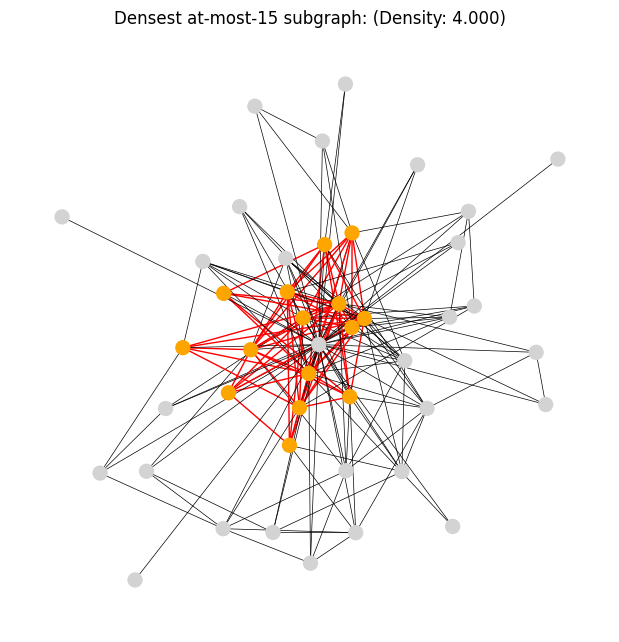

In [15]:
# get the first graph
G = nx_graphs[first_key]
G.add_nodes_from(range(1, data["size"] + 1))
G.add_edges_from(data["edges"])

# 4. Prepare Styling
highlight_nodes = set(data["damks_vlist"])

# Node Colors: Orange for the dense core, lightgrey for the rest
node_colors = [
    "orange" if node in highlight_nodes else "lightgrey" 
    for node in G.nodes()
]

# Edge Colors: Red if both endpoints are in the dense core, black otherwise
edge_colors = [
    "red" if (u in highlight_nodes and v in highlight_nodes) else "black"
    for u, v in G.edges()
]

# Edge Widths: Thick for core, thin for background
edge_widths = [
    1 if (u in highlight_nodes and v in highlight_nodes) else 0.5
    for u, v in G.edges()
]

# 5. Draw
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, k=0.15, iterations=20) # Layout for better spacing

nx.draw(
    G, pos,
    node_color=node_colors,
    edge_color=edge_colors,
    width=edge_widths,
    node_size=100,
    with_labels=False
)

plt.title(f"Densest at-most-15 subgraph: (Density: {data['damks_density']:.3f})")
plt.show()

In [17]:
K = 15

## Utility Functions and Learning-augmented DamkS Algorithm

In [20]:
# Utility functions
def build_adjacency_list(edges):
    """
        Build an adjacency list from a list of edges.
    """
    adj = defaultdict(set)
    for u, v in edges:
        adj[u].add(v)
        adj[v].add(u)
    return {u: list(neighs) for u, neighs in adj.items()}

def compute_degrees_and_avg_neighbor_degrees(adj_list):
    """
        Compute the degree of each node and the average degree of its neighbors.
    """
    degrees = {node: len(neighbors) for node, neighbors in adj_list.items()}

    avg_neighbor_degrees = {}
    for node, neighbors in adj_list.items():
        if neighbors:
            total = sum(degrees.get(neighbor, 0) for neighbor in neighbors)
            avg = total / len(neighbors)
            avg_neighbor_degrees[node] = avg
        else:
            avg_neighbor_degrees[node] = 0.0

    return degrees, avg_neighbor_degrees

def compute_density(edges, S):
    """
        Compute the density of a subgraph S given the edges of the original graph.
    """
    e_s = 0
    for u, v in edges:
        if u in S and v in S:
            e_s += 1
    return e_s / len(S) if S else 0.0


def augment_damks(edges, S, k, epsilon = 0.1):
    """
        Augmented learning algorithm for Densest at-most-k Subgraph (DamkS).
    """
    t = defaultdict(int)
    for u, v in edges:
        if u not in S and v in S:
            t[u] += 1
        if v not in S and u in S:
            t[v] += 1

        
    sorted_nodes = sorted(t.items(), key=lambda x: x[1], reverse=True)    
    num_nodes_to_add = int(len(S) * epsilon / (1 - epsilon)) # Select the top |S|*epsilon/(1-epsilon) nodes
    
    # Step 1: 
    U = [node for node, _ in sorted_nodes[:num_nodes_to_add]]    
    S.update(U) # Add these nodes to S
    
    # Step 2: Trimming step 
    while len(S) > k:
        # Remove node with lowest degree in S
        degS = defaultdict(int)
        for u, v in edges:
            if u in S and v in S:
                degS[u] += 1
                degS[v] += 1
        node_to_remove = min(S, key=lambda x: degS[x])
        S.remove(node_to_remove)
    
    density = compute_density(edges, S)
    return S, density


## Training Models to Predict DamkS 

In [30]:
training_size = int(nx_graphs[first_key].number_of_nodes() * 0.8)

count = 1
training = dict()
testing = dict()

for gn, G in nx_graphs.items():
    if count <= training_size:
        training[gn] = copy.deepcopy(G)
    else:
        testing[gn] = copy.deepcopy(G)
         
    count += 1

training_fn = "node_features_with_labels_damks.csv"
# Create CSV file and write header
with open(training_fn, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["degree", "avg_neighbor_degree", "number_of_nodes", "is_in_damks"])

for gn, G in training.items():
    adj = build_adjacency_list(G.edges())
    degrees, avg_neighbor_degrees = compute_degrees_and_avg_neighbor_degrees(adj)
    num_nodes = G.number_of_nodes()
    G.graph["degrees"] = degrees
    G.graph["avg_neighbor_degrees"] = avg_neighbor_degrees
    
    with open(training_fn, "a", newline="") as csvfile:
        for node in G.nodes():
            node_degree = degrees[node]
            node_avg_neighbor_degree = avg_neighbor_degrees[node]
            is_in_damks = 1 if node in G.graph["damks_vlist"] else 0
            G.nodes[node]["features"] = (node_degree, node_avg_neighbor_degree, num_nodes)
            G.nodes[node]["label"] = is_in_damks
            writer = csv.writer(csvfile)
            writer.writerow([node_degree, node_avg_neighbor_degree, num_nodes, is_in_damks])
            
   
    

(1169, 3) (1169,)
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       139
           1       0.90      0.86      0.88        95

    accuracy                           0.91       234
   macro avg       0.91      0.90      0.90       234
weighted avg       0.91      0.91      0.91       234



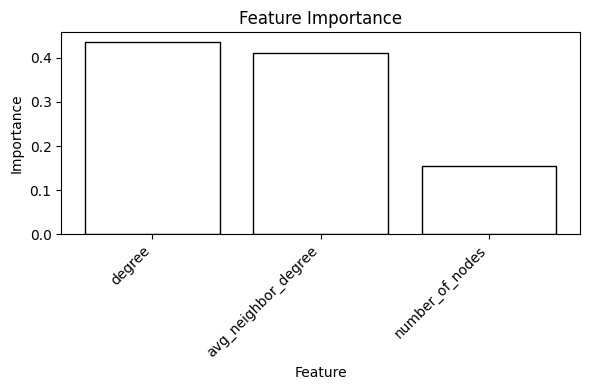

In [33]:
# Load training data from CSV
df = pd.read_csv("node_features_with_labels_damks.csv")
X = df[["degree", "avg_neighbor_degree", "number_of_nodes"]]
y = df["is_in_damks"]

print(X.shape, y.shape)


# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a Random Forest
clf = RandomForestClassifier(random_state=42, n_estimators=10)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot feature importance
importances = clf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(6, 4))
plt.bar(feature_names, importances, color='white', edgecolor='black')
plt.title("Feature Importance")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Test size: 620


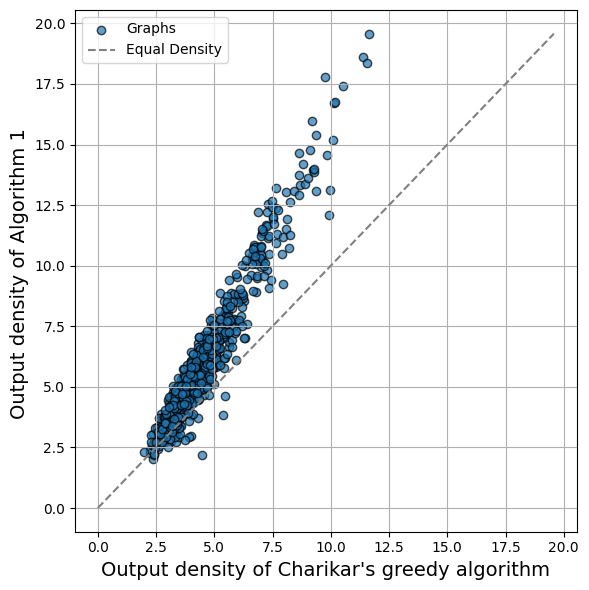

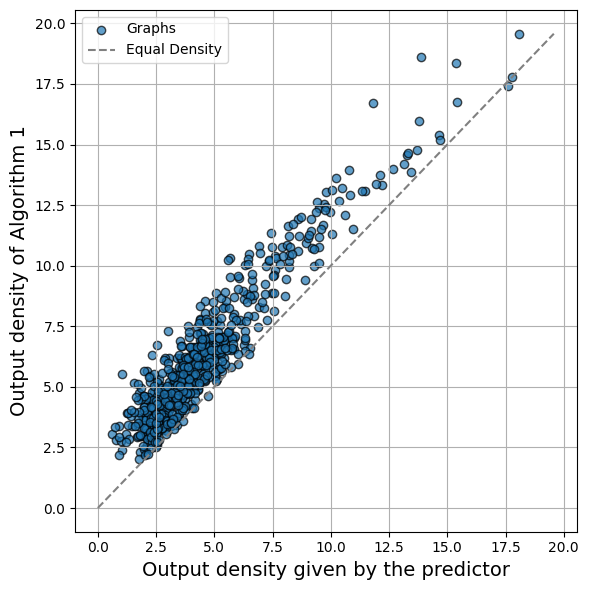

In [ ]:
for gn, G in testing.items():
    adj = build_adjacency_list(G.edges())
    degrees, avg_neighbor_degrees = compute_degrees_and_avg_neighbor_degrees(adj)
    
    # Extract features and labels for testing
    num_nodes = G.number_of_nodes()
    G.graph["degrees"] = degrees
    G.graph["avg_neighbor_degrees"] = avg_neighbor_degrees
    
    X = pd.DataFrame({
        "degree": [degrees.get(node, 0) for node in G.nodes()],
        "avg_neighbor_degree": [avg_neighbor_degrees.get(node, 0.0) for node in G.nodes()],
        "number_of_nodes": [num_nodes] * num_nodes
    })
    
    

# Iterate over the graphs for the first 100 graphs
test_size = 0

for graph_id, edges in test_data_set.items():
    if len(edges) < 100:
        continue
    test_size += 1

    adj_list = build_adjacency_list(edges)
    degrees, avg_neighbor_degrees = compute_degrees_and_avg_neighbor_degrees(adj_list)

    G = nx.Graph()
    G.add_edges_from(edges)
    clustering = nx.clustering(G)

    # Prepare features for classifier
    X = pd.DataFrame({
        "degree": [degrees.get(node, 0) for node in adj_list],
        "avg_neighbor_degree": [avg_neighbor_degrees.get(node, 0.0) for node in adj_list],
        "number_of_nodes": [len(adj_list)] * len(adj_list)
    })


    y_pred = clf.predict(X)
    S = {node for node, pred in zip(adj_list.keys(), y_pred) if pred == 1}
    
    # density without augmentation
    density = compute_density(edges, S)
    non_augmented_density.append(density)


    _, aug_density = augment_ds(edges, S, epsilon=0.2)
    augmented_density.append(aug_density)

    _, peel_density = greedy_charikar(G)
    peeling_density.append(peel_density)

print(f"Test size: {test_size}")

plt.figure(figsize=(6, 6))
plt.scatter(peeling_density, augmented_density, label="Graphs", alpha=0.7, edgecolor='black')

# Plot y = x line for reference
max_val = max(max(peeling_density), max(augmented_density))
plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', label='Equal Density')

plt.xlabel("Output density of Charikar's greedy algorithm", fontsize=14)
plt.ylabel("Output density of Algorithm 1 ", fontsize=14)
#plt.title("Augmented Learning Densest Subgraph vs. Charikar's Peeling Algorithm")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 6))
plt.scatter(non_augmented_density, augmented_density, label="Graphs", alpha=0.7, edgecolor='black')

# Plot y = x line for reference
max_val = max(max(non_augmented_density), max(augmented_density))
plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', label='Equal Density')

plt.xlabel("Output density given by the predictor", fontsize=14)
plt.ylabel("Output density of Algorithm 1", fontsize=14) 
#plt.title("Augmented Learning Densest Subgraph vs. Non-Augmented")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()







In [ ]:
# Compute % improvement of augmented over non-augmented
improvement_over_non_aug = [
    100 * (a - n) / n if n > 0 else 0
    for a, n in zip(augmented_density, non_augmented_density)
]

# Compute % improvement of augmented over Charikar peeling
improvement_over_peeling = [
    100 * (a - p) / p if p > 0 else 0
    for a, p in zip(augmented_density, peeling_density)
]

# Compute averages
avg_improvement_non_aug = np.mean(improvement_over_non_aug)
avg_improvement_peeling = np.mean(improvement_over_peeling)




# Total number of evaluated graphs
n = len(augmented_density)
# Count how often Charikar outperforms augmented
charikar_better_count = sum(
    p > a for p, a in zip(peeling_density, augmented_density)
)
# Count how often predictor (non-augmented) outperforms augmented
predictor_better_count = sum(
    n > a for n, a in zip(non_augmented_density, augmented_density)
)
# Compute percentages
charikar_better_pct = 100 * charikar_better_count / n
predictor_better_pct = 100 * predictor_better_count / n



# Compute % improvement of augmented over non-augmented
improvement_over_non_aug = [
    100 * (a - n) / n if n > 0 else 0
    for a, n in zip(augmented_density, non_augmented_density)
]

# Compute % improvement of augmented over Charikar
improvement_over_peeling = [
    100 * (a - p) / p if p > 0 else 0
    for a, p in zip(augmented_density, peeling_density)
]

# Max and min improvements
max_improve_non_aug = max(improvement_over_non_aug)
min_improve_non_aug = min(improvement_over_non_aug)

max_improve_peeling = max(improvement_over_peeling)
min_improve_peeling = min(improvement_over_peeling)

print("Reports:")
print("-----------------------------------------------------")
print(f"Average % improvement over predictor's solution: {avg_improvement_non_aug:.2f}%")
print(f"Average % improvement over Charikar's greedy: {avg_improvement_peeling:.2f}%")
print("-----------------------------------------------------")
print(f"Charikar's greedy is better on {charikar_better_count}/{n} graphs ({charikar_better_pct:.2f}%)")
print(f"Predictor's solution is better on {predictor_better_count}/{n} graphs ({predictor_better_pct:.2f}%)")
print("-----------------------------------------------------")
print(f"Charikar's greedy is better on {charikar_better_count}/{n} graphs ({charikar_better_pct:.2f}%)")
print(f"Predictor's solution is better on {predictor_better_count}/{n} graphs ({predictor_better_pct:.2f}%)")
print("-----------------------------------------------------")
print(f"Max improvement over predictor's solution: {max_improve_non_aug:.2f}%")
print(f"Worst degradation vs predictor's solution: {min_improve_non_aug:.2f}%")
print("-----------------------------------------------------")
print(f"Max improvement over Charikar's greedy: {max_improve_peeling:.2f}%")
print(f"Worst degradation vs Charikar's greedy: {min_improve_peeling:.2f}%")



Average % improvement over non-augmented: 37.71%
Average % improvement over Charikar peeling: 32.80%
Reports:
-----------------------------------------------------
Charikar's greedy is better on 52/1001 graphs (5.19%)
Predictor's solution is better on 17/1001 graphs (1.70%)
-----------------------------------------------------
Charikar's greedy is better on 52/1001 graphs (5.19%)
Predictor's solution is better on 17/1001 graphs (1.70%)
-----------------------------------------------------
Max improvement over predictor: 372.22%
Worst degradation vs predictor: -15.85%
-----------------------------------------------------
Max improvement over Charikar: 79.86%
Worst degradation vs Charikar: -79.63%


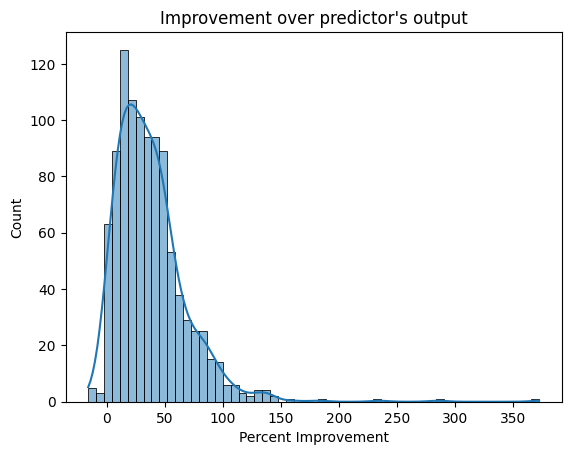

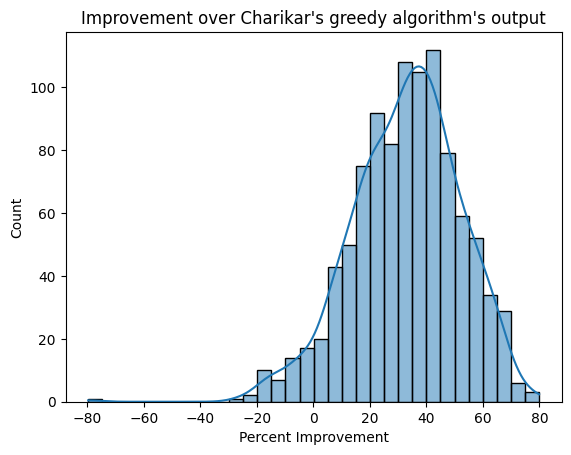

In [21]:
import seaborn as sns

sns.histplot(improvement_over_non_aug, kde=True)
plt.title("Improvement over predictor's output")
plt.xlabel("Percent Improvement")
plt.show()

sns.histplot(improvement_over_peeling, kde=True)
plt.title("Improvement over Charikar's greedy algorithm's output")
plt.xlabel("Percent Improvement")
plt.show()
